In [1]:
from google.colab import files
uploaded = files.upload()

Saving online_retail.csv to online_retail.csv


In [4]:
import pandas as pd

# Read the uploaded CSV file
df = pd.read_csv('online_retail.csv')

# Display the first few rows
df.head()


Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [9]:
# ➕ Add TotalPrice column (Quantity × Price)
df['TotalPrice'] = df['Quantity'] * df['Price']

# Confirm it exists
df[['Quantity', 'Price', 'TotalPrice']].head()

Quantity  Price  TotalPrice
0        12   6.95        83.4
1        12   6.75        81.0
2        12   6.75        81.0
3        48   2.10       100.8
4        24   1.25        30.0

In [13]:
# Ensure datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reference date for recency calculation (1 day after last purchase)
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics per Customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Preview
rfm.head()

Customer ID  Recency  Frequency  Monetary
0      12346.0      326         17    -64.68
1      12347.0        2          8   5633.32
2      12348.0       75          5   2019.40
3      12349.0       19          5   4404.54
4      12350.0      310          1    334.40

In [14]:
# Quantile scoring
r_labels = [5, 4, 3, 2, 1]
f_labels = m_labels = [1, 2, 3, 4, 5]

# Assign R, F, M scores
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=m_labels)

# Create combined RFM score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Preview
rfm.head()


Customer ID  Recency  Frequency  Monetary  R  F  M RFM_Score
0      12346.0      326         17    -64.68  2  5  1       251
1      12347.0        2          8   5633.32  5  4  5       545
2      12348.0       75          5   2019.40  3  3  4       334
3      12349.0       19          5   4404.54  4  3  5       435
4      12350.0      310          1    334.40  2  1  2       212

In [15]:
def rfm_segment(row):
    r = int(row['R'])
    f = int(row['F'])
    m = int(row['M'])

    if r == 5 and f == 5:
        return 'Champions'
    elif r >= 4 and f >= 4:
        return 'Loyal Customers'
    elif r == 5 and f <= 3:
        return 'New Customers'
    elif r >= 3 and f <= 2:
        return 'Potential Loyalists'
    elif r <= 2 and f >= 4:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Need Attention'


In [16]:
rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

In [17]:
# Save full RFM data
rfm.to_csv("rfm_segments.csv", index=False)

# Show download link
from IPython.display import FileLink
FileLink("rfm_segments.csv")

/content/rfm_segments.csv

In [18]:
df_merged = df.merge(
    rfm[['Customer ID', 'R', 'F', 'M', 'RFM_Score', 'Segment']],
    on='Customer ID',
    how='left'
)

# Preview merged dataset
df_merged.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  R  F  \
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  3  4   
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  3  4   
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  3  4   
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom       100.8  3  4   
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom        30.0  3  4   

   M RFM_Score         Segment  
0  4       344  Need Attention  
1  4       344  Need Attention  
2  4       344  Need Attention  
3  4       344  Need Attention  
4  4       344  Need Attention

In [20]:
from IPython.display import display, Markdown

# Generate key business stats
summary_stats = {
    "Total Customers": df_merged['Customer ID'].nunique(),
    "Total Transactions": df_merged['Invoice'].nunique(),
    "Total Revenue": f"${df_merged['Price'].sum():,.2f}",
    "Average Order Value": f"${df_merged['Price'].mean():.2f}",
    "Most Common Country": df_merged['Country'].mode()[0],
    "Most Common Segment": df_merged['Segment'].mode()[0],
}

# Display as Markdown table
display(Markdown("### 📋 Key Business Summary"))
for k, v in summary_stats.items():
    print(f"{k}: {v}")

### 📋 Key Business Summary

Total Customers: 5942
Total Transactions: 53628
Total Revenue: $4,962,621.63
Average Order Value: $4.65
Most Common Country: United Kingdom
Most Common Segment: Champions


/tmp/ipython-input-21-2443329750.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


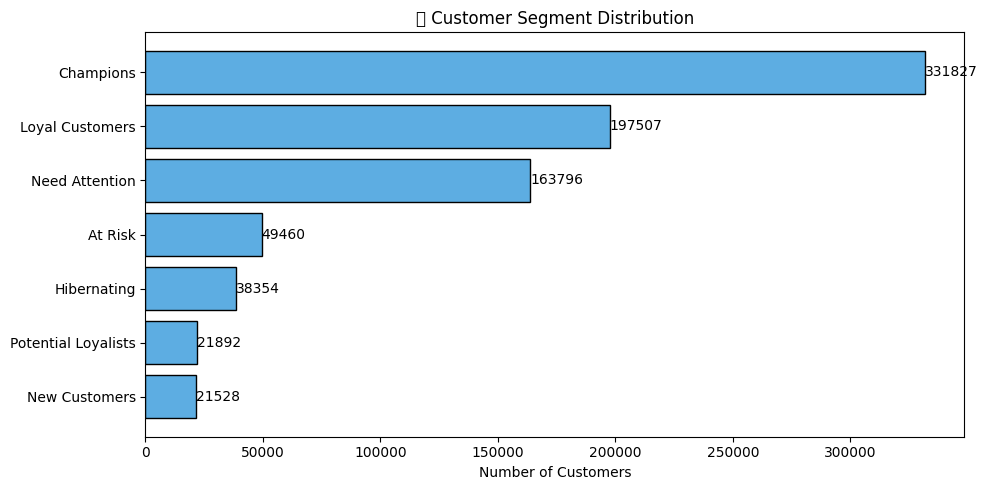

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
segment_counts = df_merged['Segment'].value_counts().sort_values()
bars = plt.barh(segment_counts.index, segment_counts.values, color="#5DADE2", edgecolor="black")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 3, bar.get_y() + bar.get_height()/2,
             str(width), va='center')

plt.title('📊 Customer Segment Distribution')
plt.xlabel('Number of Customers')
plt.tight_layout()
plt.show()

/tmp/ipython-input-22-206658776.py:11: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


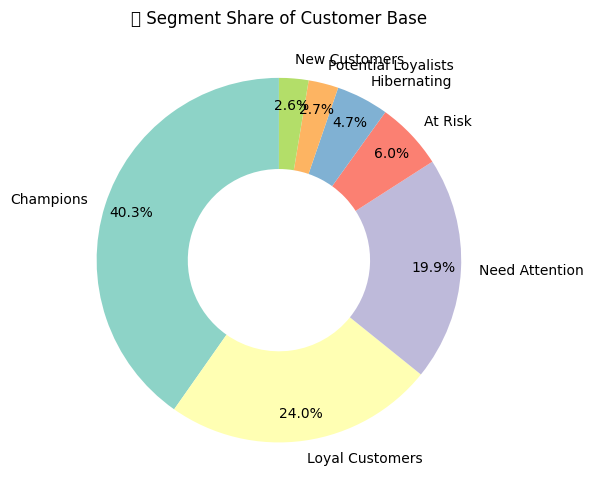

In [22]:
plt.figure(figsize=(6,6))
df_merged['Segment'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors,
    wedgeprops=dict(width=0.5),
    pctdistance=0.85
)
plt.title('🧩 Segment Share of Customer Base')
plt.ylabel('')
plt.tight_layout()
plt.show()


/tmp/ipython-input-23-3831281938.py:9: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


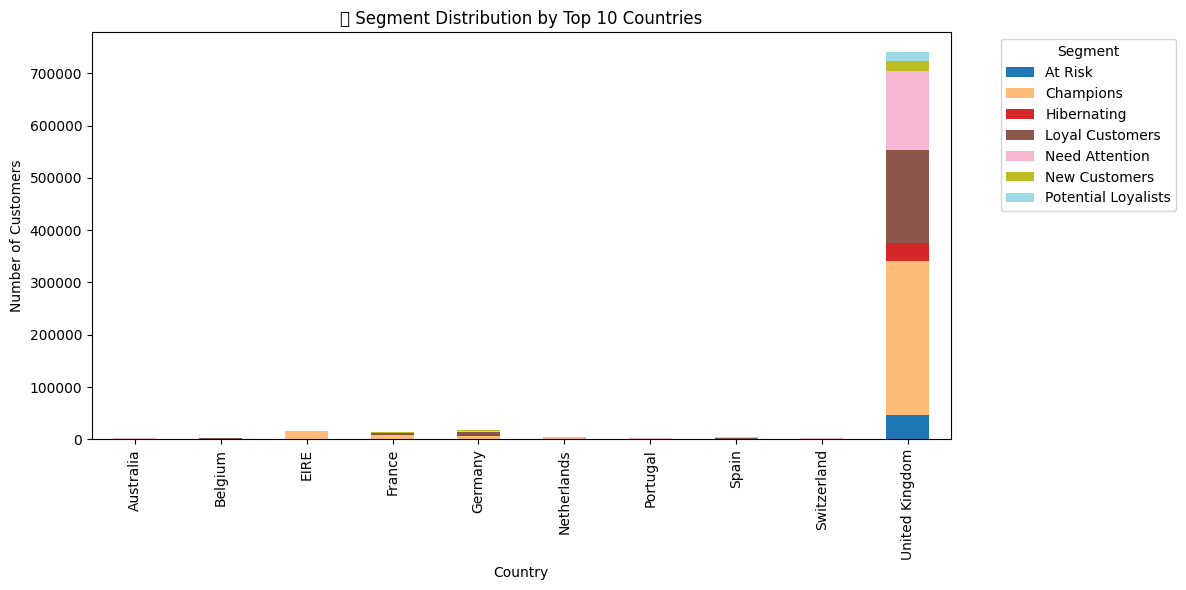

In [23]:
top_countries = df_merged['Country'].value_counts().head(10).index
country_segment = df_merged[df_merged['Country'].isin(top_countries)].groupby(['Country', 'Segment']).size().unstack().fillna(0)

country_segment.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title("🌍 Segment Distribution by Top 10 Countries")
plt.ylabel("Number of Customers")
plt.xlabel("Country")
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Save merged dataset
df_merged.to_csv("full_dataset_with_rfm.csv", index=False)